## Import libs

In [571]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial.transform import Rotation

from src.imu import IMUData
from src.quaternion import Quaternion
from src.madgwick import MadgwickFilter
from src.kalman import KalmanFilter, rotation_matrix, calculate_trajectory

import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Load dataset

In [572]:
imu_data_mh01 = pd.read_csv("mh01_easy/imu0/data.csv")
imu_data_mh02 = pd.read_csv("mh02_easy/imu0/data.csv")
imu_data_mh03 = pd.read_csv("mh03_medium/imu0/data.csv")
imu_data_mh04 = pd.read_csv("mh04_diff/imu0/data.csv")
imu_data_mh05 = pd.read_csv("mh05_diff/imu0/data.csv")

In [573]:
imu_data_mh01.columns = imu_data_mh01.columns.str.strip()
imu_data_mh02.columns = imu_data_mh02.columns.str.strip()
imu_data_mh03.columns = imu_data_mh03.columns.str.strip()
imu_data_mh04.columns = imu_data_mh04.columns.str.strip()
imu_data_mh05.columns = imu_data_mh05.columns.str.strip()

In [574]:
imu_data_mh01.head()

,#timestamp [ns],w_RS_S_x [rad s^-1],w_RS_S_y [rad s^-1],w_RS_S_z [rad s^-1],a_RS_S_x [m s^-2],a_RS_S_y [m s^-2],a_RS_S_z [m s^-2]
0,1403636579758555392,-0.099135,0.147306,0.027227,8.147692,-0.375922,-2.402629
1,1403636579763555584,-0.099135,0.140324,0.029322,8.033281,-0.408610,-2.402629
2,1403636579768555520,-0.098437,0.127758,0.037699,7.886181,-0.424955,-2.435318
3,1403636579773555456,-0.102625,0.115890,0.045379,7.828976,-0.375922,-2.468007
4,1403636579778555392,-0.105418,0.108210,0.051662,7.714565,-0.408610,-2.557901


In [575]:
def read_ground_truth(dataset):
  ground_truth = pd.read_csv(dataset + "/state_groundtruth_estimate0/data.csv")
  ground_truth.columns = ground_truth.columns.str.strip()
  ground_truth = ground_truth[['#timestamp', 'p_RS_R_x [m]', 'p_RS_R_y [m]', 'p_RS_R_z [m]', 'q_RS_w []', 'q_RS_x []', 'q_RS_y []', 'q_RS_z []', 'v_RS_R_x [m s^-1]','v_RS_R_y [m s^-1]', 'v_RS_R_z [m s^-1]']]
  return ground_truth

In [576]:
ground_truth_mh01 = read_ground_truth("mh01_easy")
ground_truth_mh02 = read_ground_truth("mh02_easy")
ground_truth_mh03 = read_ground_truth("mh03_medium")
ground_truth_mh04 = read_ground_truth("mh04_diff")
ground_truth_mh05 = read_ground_truth("mh05_diff")

In [577]:
def create_complete_dataset(imu_data, ground_truth, dim=3):
  imu_data['#timestamp [ns]'] = pd.to_datetime(imu_data['#timestamp [ns]'], unit='ns')
  ground_truth['#timestamp'] = pd.to_datetime(ground_truth['#timestamp'], unit='ns')

  imu_data.set_index('#timestamp [ns]', inplace=True)
  ground_truth.set_index('#timestamp', inplace=True)

  complete_data = pd.merge_asof(
      imu_data, ground_truth, left_index=True, right_index=True, direction='nearest', tolerance=pd.Timedelta('900ns')
  )

  # Drop rows where no match was found (NaN values from unmatched timestamps)
  complete_data = complete_data.dropna()
  complete_data.columns = complete_data.columns.str.split(" ").str[0]
  return complete_data

In [578]:
complete_dataset_mh01 = create_complete_dataset(imu_data_mh01, ground_truth_mh01)
complete_dataset_mh02 = create_complete_dataset(imu_data_mh02, ground_truth_mh02)
complete_dataset_mh03 = create_complete_dataset(imu_data_mh03, ground_truth_mh03)
complete_dataset_mh04 = create_complete_dataset(imu_data_mh04, ground_truth_mh04)
complete_dataset_mh05 = create_complete_dataset(imu_data_mh05, ground_truth_mh05)

In [579]:
complete_dataset_mh05.head()

,w_RS_S_x,w_RS_S_y,w_RS_S_z,a_RS_S_x,a_RS_S_y,a_RS_S_z,p_RS_R_x,p_RS_R_y,p_RS_R_z,q_RS_w,q_RS_x,q_RS_y,q_RS_z,v_RS_R_x,v_RS_R_y,v_RS_R_z
#timestamp [ns],,,,,,,,,,,,,,,,
2014-06-24 19:35:19.492829440,-0.006283,0.020246,0.078191,8.989429,-0.057205,-3.816421,4.460675,-1.680515,0.579614,0.238261,-0.757610,-0.348629,-0.497711,0.006246,-0.001431,-0.004391
2014-06-24 19:35:19.497829376,-0.001396,0.018850,0.082380,9.030290,-0.008172,-3.775560,4.460706,-1.680523,0.579592,0.238261,-0.757616,-0.348621,-0.497709,0.006108,-0.001439,-0.004327
2014-06-24 19:35:19.502829568,-0.005585,0.021642,0.079587,9.022118,-0.049033,-3.791905,4.460736,-1.680530,0.579571,0.238262,-0.757621,-0.348612,-0.497706,0.006043,-0.001394,-0.004211
2014-06-24 19:35:19.507829504,0.000698,0.018151,0.080285,9.038462,-0.049033,-3.800077,4.460766,-1.680536,0.579550,0.238264,-0.757625,-0.348606,-0.497703,0.005870,-0.001320,-0.004051
2014-06-24 19:35:19.512829440,-0.002094,0.023038,0.078191,9.022118,-0.032689,-3.775560,4.460795,-1.680543,0.579530,0.238268,-0.757627,-0.348603,-0.497700,0.005754,-0.001244,-0.003908


In [580]:
def plot_trajectory(position, title='3D Trajectory Plot'): 
    """plot trajectory, cosider here top down view"""
    fig = go.Figure(data=[go.Scatter3d(
        x=position[:, 0],
        y=position[:, 1],
        z=position[:, 2],
        mode='markers+lines',
        marker=dict(size=1)
    )])

    fig.update_layout(
        scene=dict(
            xaxis_title='X Position',
            yaxis_title='Y Position',
            zaxis_title='Z Position'
        ),
        title=title
    )

    fig.show()

In [581]:
def compute_metrics(estimated, ground_truth):
    mse = mean_squared_error(ground_truth, estimated)
    r2 = r2_score(ground_truth, estimated)

    return {
        'MSE': mse,
        'R2': r2
    }

## Prep data

In [582]:
df = complete_dataset_mh05.copy()[1_000:1_500]
# df = complete_dataset_mh04.copy()[3_000:5_000] 


timestamp = df.index.values
gyro_data = df[['w_RS_S_x', 'w_RS_S_y', 'w_RS_S_z']].values
acc_data = df[['a_RS_S_x', 'a_RS_S_y', 'a_RS_S_z']].values
position_data = df[['p_RS_R_x', 'p_RS_R_y', 'p_RS_R_z']].values
orientation_q = df[['q_RS_w', 'q_RS_x' , 'q_RS_y', 'q_RS_z']].values
orientation_v = df[['v_RS_R_x', 'v_RS_R_y' , 'v_RS_R_z']].values

sampling_rate = 200
delta_t = 1/sampling_rate

In [583]:
# plot the ground truth trajectory 
# consider top-down view
plot_trajectory(position_data)

## Zero-Correction Kinematic Estimation

In [584]:
orientation = Rotation.from_quat([[1, 0, 0, 0]])
gravity = np.array([0, 0, -9.81])

velocity = np.zeros_like(acc_data)
position = np.zeros_like(acc_data)

for i in range(1, len(acc_data)):
    gyro_delta = gyro_data[i - 1] * delta_t
    orientation = orientation * Rotation.from_rotvec(gyro_delta)

    # rotate acc to global frame and sub gravity
    acc_GF = orientation.apply(acc_data[i - 1]) + gravity

    velocity[i] = velocity[i - 1] + acc_GF * delta_t
    position[i] = position[i - 1] + velocity[i] * delta_t

plot_trajectory(position)
compute_metrics(position, position_data)

{'MSE': 53.54000434254517, 'R2': -5888.853636839757}

## Complementary Filter

In [585]:
def complementary_filter(acc, gyro, delta_t, alpha=0.98):
    """Complementary filter
    Args:
        acc (np.ndarray): acceleration in m/s^2
        gyro (np.ndarray): angular velocity in rad/s
    Returns:
        att (np.ndarray): estimated orientation angles (roll, pitch, yaw)
    """
    att = np.zeros_like(acc)
    for i in range(1, len(acc)):
        # compute angles from acc (roll, pitch, yaw)
        roll = np.arctan2(acc[i][1], np.sqrt(acc[i][0]**2 + acc[i][2]**2))
        pitch = np.arctan2(acc[i][0], np.sqrt(acc[i][1]**2 + acc[i][2]**2))
        yaw = att[i-1][2]

        acc_att = np.array([roll, pitch, yaw])
        gyro_att = att[i-1] + gyro[i] * delta_t

        # fuse gyro and acc 
        att[i] = alpha * gyro_att + (1 - alpha) * acc_att

    return att

In [586]:
attitudes = complementary_filter(acc_data, gyro_data, delta_t)

In [587]:
attitudes

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.70785256e-04,  2.57554387e-02,  6.60223149e-04],
       [-1.92964691e-04,  5.10320489e-02,  1.30676292e-03],
       ...,
       [-5.13068892e-02,  1.21812135e+00,  2.59248764e-01],
       [-5.31144186e-02,  1.21779195e+00,  2.60008191e-01],
       [-5.47546372e-02,  1.21735448e+00,  2.60822352e-01]])

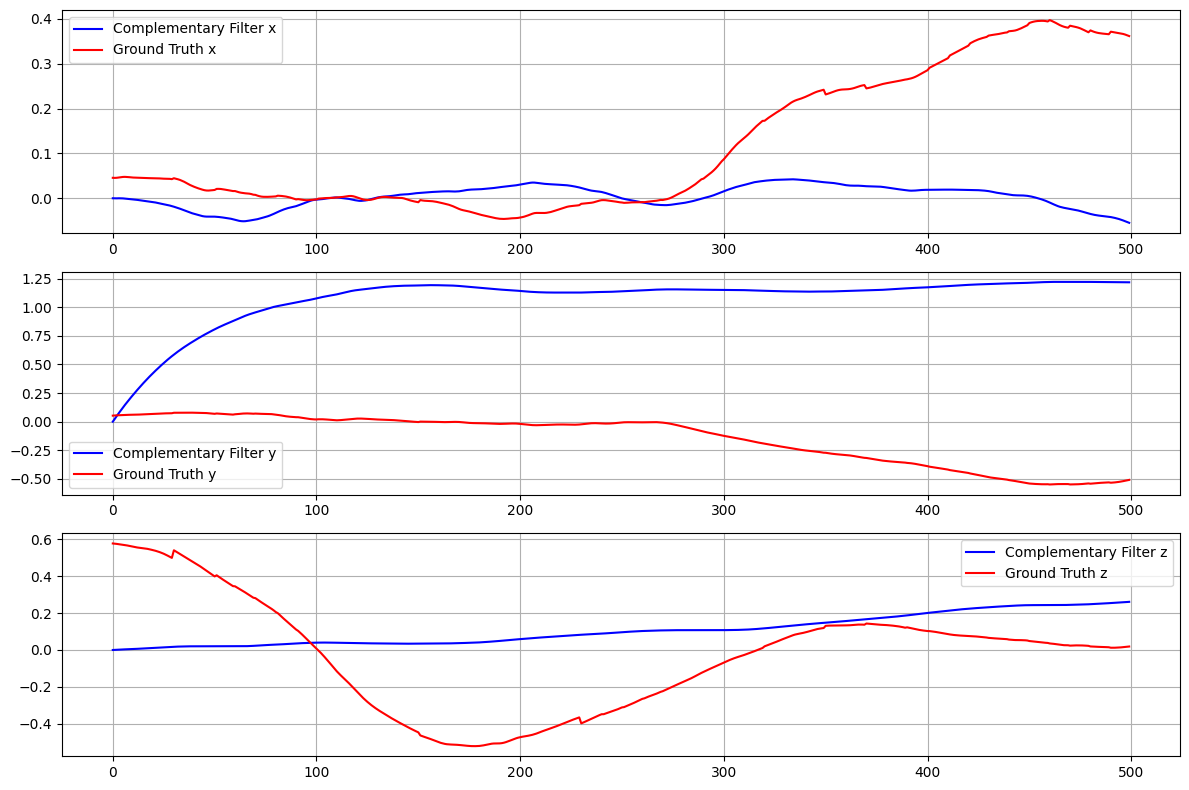

In [588]:
plt.figure(figsize=(12, 8))

for i, component in enumerate(['x', 'y', 'z']):
    plt.subplot(3, 1, i+1)
    plt.plot(np.array(attitudes)[:, i], label=f'Complementary Filter {component}', color='b')
    plt.plot(orientation_v[:, i], label=f'Ground Truth {component}', color='r')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [589]:
def rotation_matrix_from_euler(roll, pitch, yaw):
    r = Rotation.from_euler('xyz', [roll, pitch, yaw], degrees=False)
    return r.as_matrix()

In [590]:
def compute_position(attitudes, acc_data):
    velocity = np.zeros_like(acc_data)
    position = np.zeros_like(acc_data)
    acc_WF = np.zeros_like(acc_data)
    gravity = np.array([0, 0, -9.81])

    for i in range(1, len(timestamp)):
        roll, pitch, yaw = attitudes[i][0], attitudes[i][1], attitudes[i][2]

        roll = np.radians(roll)
        pitch = np.radians(pitch)
        yaw = np.radians(yaw)
        
        R_matrix = rotation_matrix_from_euler(roll, pitch, yaw)
        acc_WF[i] = R_matrix @ acc_data[i] + gravity
        
        velocity[i] = velocity[i-1] + acc_WF[i] * delta_t
        position[i] = position[i-1] + velocity[i] * delta_t

    return position

In [591]:
position = compute_position(attitudes, acc_data)
plot_trajectory(position)
compute_metrics(position, position_data)

{'MSE': 148.59380021109152, 'R2': -12475.41492637721}

## Madgwick Filter

In [592]:
imu_data_madgwick = IMUData(
    timestamp=timestamp,
    gyro=gyro_data,
    acc=acc_data,
    orientation=orientation_q,
    sampling_rate=sampling_rate
)

imu_data_madgwick.process_imu_data()

In [593]:
# rmse_values_combined = {}
# beta_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.5]
# gamma_values = [0.1, 0.3, 0.5, 0.7, 1.0]

# for beta in beta_values:
#     for gamma in gamma_values:
#         madgwick_filter = MadgwickFilter(
#             # initial_quaternion=Quaternion(orientation[0]),
#             sampling_rate=sampling_rate,
#             beta=beta,
#             gamma=gamma,
#             k=1
#         )

#         results = []
#         for timestamp, gyro, acc in imu_data:
#             result = madgwick_filter.update(q_w=gyro, q_a=acc)
#             results.append(result)
        
#         predicted_orientation = np.array(results)
        
#         rmse = np.sqrt(mean_squared_error(orientation, predicted_orientation))
#         rmse_values_combined[(beta, gamma)] = rmse
#         print(f"Beta: {beta}, Gamma: {gamma}, RMSE: {rmse}")

# best_combination = min(rmse_values_combined, key=rmse_values_combined.get)
# best_beta, best_gamma = best_combination
# print(f"Best Beta: {best_beta}, Best Gamma: {best_gamma} with RMSE: {rmse_values_combined[best_combination]}")

In [594]:
madgwick_filter = MadgwickFilter(
    # initial_quaternion=Quaternion(orientation_q[0]),
    sampling_rate=sampling_rate,
    beta=0.01,
    gamma=0.7,
    k=1
)

attitudes = []
for g, a in imu_data_madgwick:
    attitude = madgwick_filter.update(q_w=g, q_a=a)
    attitudes.append(attitude)

attitudes = np.array(attitudes)
attitudes

array([[ 9.99977240e-01,  6.07381807e-05, -6.74585915e-03,
         9.73905310e-05],
       [ 9.99908922e-01,  7.77977826e-05, -1.34944860e-02,
         2.01032769e-04],
       [ 9.99795089e-01,  4.42462409e-05, -2.02406836e-02,
         3.04141613e-04],
       ...,
       [ 5.78342169e-01, -1.50639118e-01, -7.99002191e-01,
        -6.65108304e-02],
       [ 5.77543045e-01, -1.50189615e-01, -8.00036558e-01,
        -6.18758187e-02],
       [ 5.76925257e-01, -1.49806158e-01, -8.00892031e-01,
        -5.73351315e-02]])

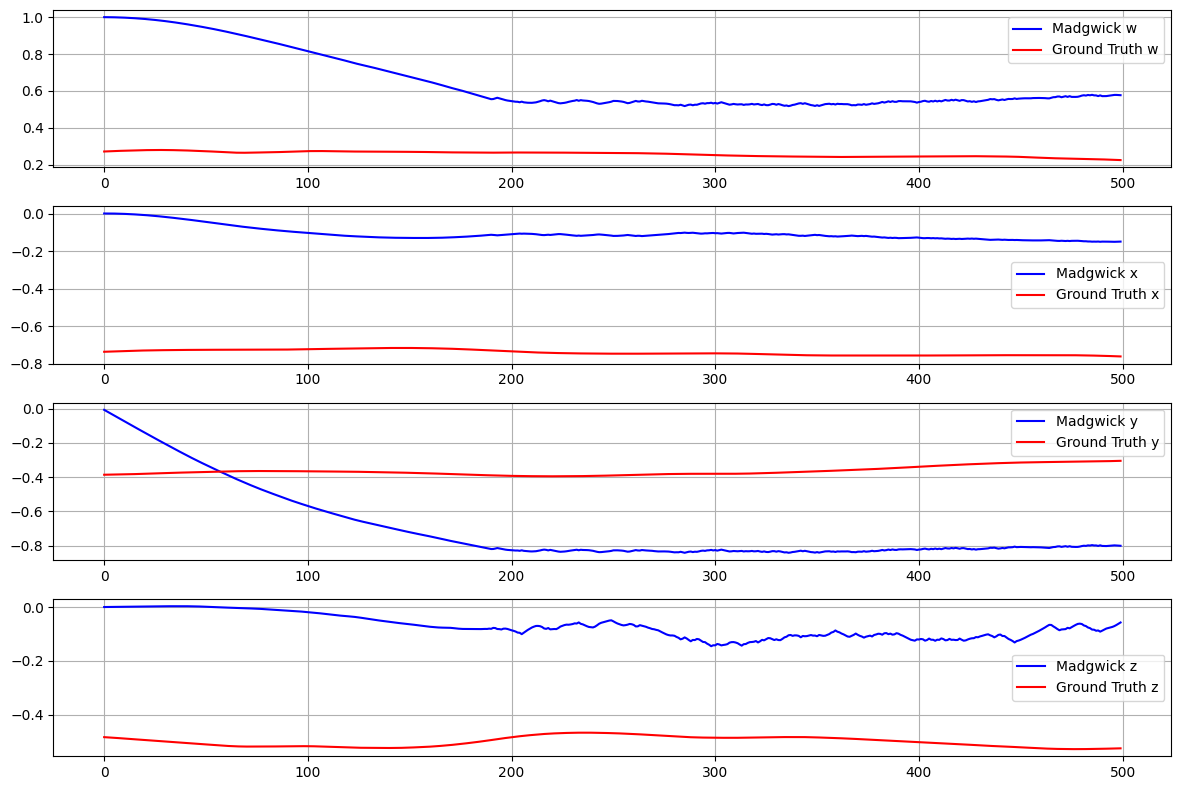

In [595]:
plt.figure(figsize=(12, 8))

for i, component in enumerate(['w', 'x', 'y', 'z']):
    plt.subplot(4, 1, i+1)
    plt.plot(attitudes[:, i], label=f'Madgwick {component}', color='b')
    plt.plot(orientation_q[:, i], label=f'Ground Truth {component}', color='r')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [596]:
orientation = Rotation.from_quat([1, 0, 0, 0]) # identity quaternion
gravity = np.array([0, 0, -9.81]) 

velocity = np.zeros_like(acc_data)
position = np.zeros_like(acc_data)

for i in range(1, len(acc_data)):
    orientation = orientation * Rotation.from_quat(attitudes[i])

    acc_global = orientation.apply(acc_data[i]) + gravity

    velocity[i] = velocity[i - 1] + acc_global * delta_t
    position[i] = position[i - 1] + velocity[i] * delta_t

plot_trajectory(position)
compute_metrics(position, position_data)


{'MSE': 92.82478188765401, 'R2': -8524.01335921568}

## Kalman Filter

In [597]:
imu_data_kalman = IMUData(
    timestamp=timestamp,
    gyro=gyro_data,
    acc=acc_data,
    orientation=orientation_v,
    sampling_rate=sampling_rate
)

In [598]:
# kf = KalmanFilter(sampling_rate=sampling_rate)
kf = KalmanFilter(sampling_rate=sampling_rate,
                gyro_noise_density=1.6968e-04,
                gyro_random_walk=1.9393e-05,
                acc_noise_density=2.0000e-3,
                acc_random_walk=3.0000e-3)
position, attitude = calculate_trajectory(gyro_data, acc_data, kf)

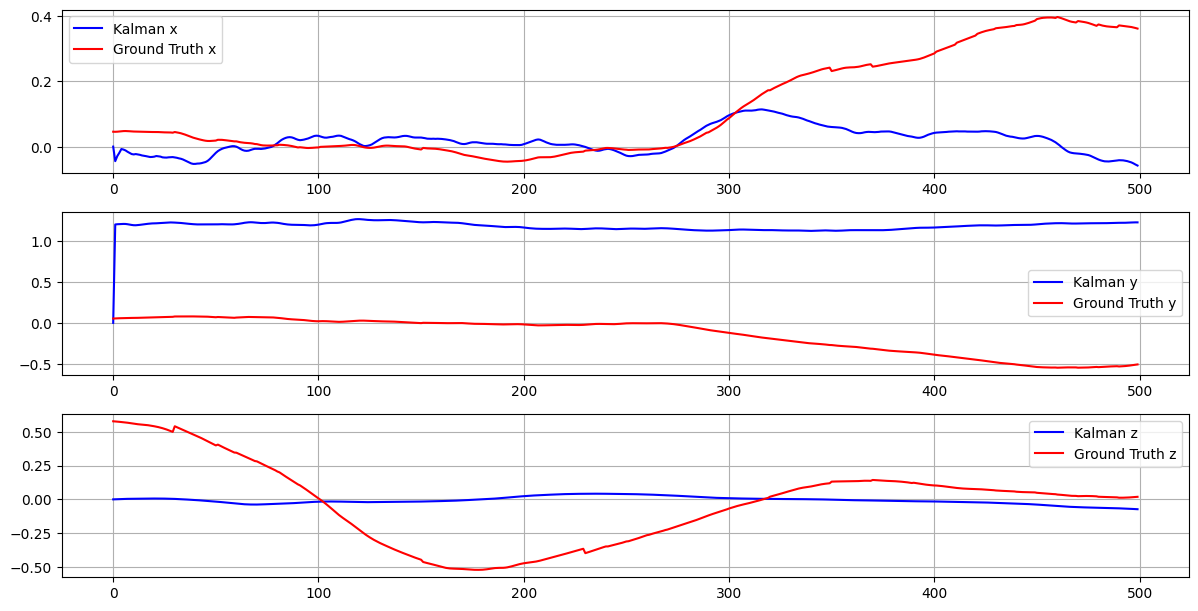

In [599]:
plt.figure(figsize=(12, 8))

for i, component in enumerate(['x', 'y', 'z']):
    plt.subplot(4, 1, i+1)
    plt.plot(attitude[:, i], label=f'Kalman {component}', color='b')
    plt.plot(orientation_v[:, i], label=f'Ground Truth {component}', color='r')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [600]:
plot_trajectory(position)
compute_metrics(position, position_data)

{'MSE': 250.2904652856606, 'R2': -17708.404724041822}